In [1]:
%matplotlib inline

In [2]:
import numpy as np
import os.path as osp
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch

import sys
sys.path.append("..")
from tools.utils import sample_input
from metrics.calc_info import calc_information_for_epoch_KDE
from models import mlp_mnist
from datasets import load_dataset

In [3]:
data_root = "../data"
model_root = "../saved-models/dataset=mnist_model=mlp"

In [5]:
train_loader_sample, _ = load_dataset(
    dataset="mnist", data_root=data_root,
    batch_size=1, shuffle_train=False, data_aug_train=False
)

sampled_inputs, sampled_labels = sample_input(
    num_classes=10, data_loader=train_loader_sample, 
    num_per_class=200, device=torch.device("cuda")
)

net = mlp_mnist().cuda()
print(net)

MLP_MNIST(
  (linear1): Linear(in_features=784, out_features=1024, bias=False)
  (linear2): Linear(in_features=1024, out_features=256, bias=False)
  (linear3): Linear(in_features=256, out_features=128, bias=False)
  (linear4): Linear(in_features=128, out_features=64, bias=False)
  (linear5): Linear(in_features=64, out_features=10, bias=False)
  (relu): ReLU()
)


In [6]:
epoch_list = list(range(0, 501, 5))
HS_list = []
ISY_list = []

for e in tqdm(epoch_list):
    
    # load the model
    net.load_state_dict(torch.load(osp.join(model_root, f'model_{e}.pkl'), map_location=torch.device("cuda")))
    net.eval()

    # generate the gating states
    with torch.no_grad():
        _ = net(sampled_inputs)
        sigma = [t.flatten(start_dim=1) for t in net.sigma_list]
        sigma = torch.cat(sigma, dim=1)
    sigma = [sigma, sampled_labels]

    # evaluate the transformation complexity
    network_info = calc_information_for_epoch_KDE(sigma, device=0)
    HS = network_info[0]['local_IXT']
    ISY = network_info[0]['local_ITY']

    HS_list.append(HS)
    ISY_list.append(ISY)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:51<00:00,  1.96it/s]


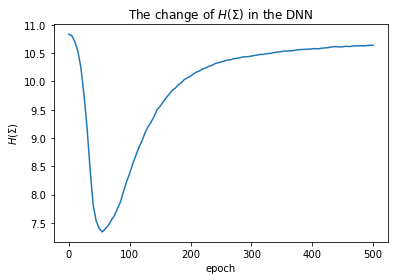

In [7]:
plt.figure()
plt.title(r"The change of $H(\Sigma)$ in the DNN")
plt.xlabel("epoch")
plt.ylabel(r"$H(\Sigma)$")
plt.plot(epoch_list, HS_list)
plt.show()

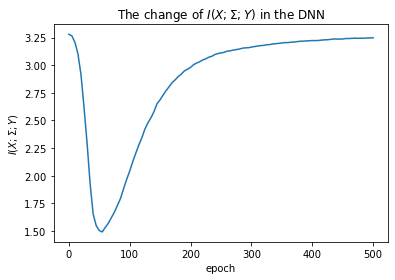

In [8]:
plt.figure()
plt.title(r"The change of $I(X;\Sigma;Y)$ in the DNN")
plt.xlabel("epoch")
plt.ylabel(r"$I(X;\Sigma;Y)$")
plt.plot(epoch_list, ISY_list)
plt.show()

In [9]:
# check the activation rates for epoch 0, 55, 500
epoch_list = [0, 55, 500]
act_rate_dict = {}
for e in tqdm(epoch_list):
    
    net.load_state_dict(torch.load(osp.join(model_root, f'model_{e}.pkl'), map_location=torch.device("cuda")))
    net.eval()

    with torch.no_grad():
        _ = net(sampled_inputs)
        sigma = [t.flatten(start_dim=1) for t in net.sigma_list]
        sigma = torch.cat(sigma, dim=1)
    act_rate = sigma.mean(dim=0).cpu().numpy()

    act_rate_dict[e] = act_rate

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 25.95it/s]


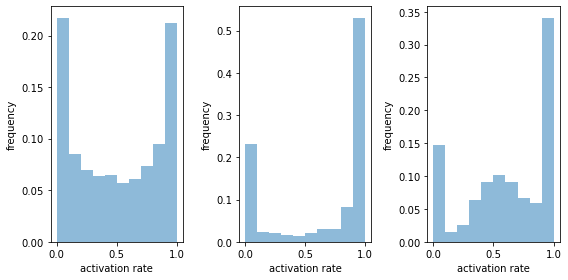

In [10]:
plt.figure(figsize=(8, 4))
for i, (e, act_rate) in enumerate(act_rate_dict.items()):
    plt.subplot(1, len(act_rate_dict), i + 1)
    plt.xlabel("activation rate")
    plt.ylabel("frequency")
    plt.hist(act_rate, bins=10, range=(0.0, 1.0),
             weights=np.ones_like(act_rate) / len(act_rate), alpha=0.5)
plt.tight_layout()
plt.savefig(osp.join(model_root, f"act_rate.png"))